## Boundary Layer Model - V03

Comparison with RAD data collocated to SAR: using r* and v*

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Custom
import functions as f
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

import warnings
warnings.filterwarnings("ignore")

In [2]:
PTHS = {
    'sav_dir':     '/home/arthur/results/TCsLifeMonitFromObs/11_BL_v02_comp_wRAD/',
    'collocs_pth': '/home/arthur/results/ck22model/Radiometer_MAXSS/02_colocate_rad_sar/ds_col_rad_sar.nc'
}

In [3]:
def coriolis(lat):
    '''Absolute vorticity.
    Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

In [4]:
### OPEN SAR DATA
dsg_sar  = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc')
dsg2_sar = xr.open_dataset('/home/arthur/results/TCsLifeMonitFromObs/07_SAR_K10/ds_glob.nc')
dsg_sar['Vmax_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2_sar['Vmax_dot_smth_IBT']),
    coords={'time': dsg_sar.time}
)

### OPEN COLLOCS
ds_col = xr.open_dataset(PTHS['collocs_pth'])

In [15]:
listOfDatasets = []

for i, _ in tqdm(enumerate(ds_col.i)):
    # Open files
    dsc         = ds_col.isel(i=i)
    sar_pth     = dsc.sar_pth.item()
    rad_pth     = dsc.rad_pth.item()
    ds_sar      = xr.open_dataset(sar_pth).isel(time=0)
    ds_rad      = xr.open_dataset(rad_pth)

    ### ==> ASYMMETRIES
    dss          = dsg_sar.where(dsg_sar.sat_pth == sar_pth, drop=True).isel(time=0)
    rs_star      = np.linspace(0, 15, 61)
    std_prof_sar = (ds_sar.wind_speed / ds_sar.wind_speed.max(dim=['theta'])).std(dim='theta', skipna=True)
    std_prof_rad = (ds_rad.wind_speed / ds_rad.wind_speed.max(dim=['theta'])).std(dim='theta', skipna=True)
    if ~np.isnan(dss.Rmax_1D):
        # Radiometer asymmetry must be valid
        valids_rad = ds_rad.where(ds_rad.wind_speed.notnull().sum(dim='theta') > 200) # Possible points: 361 (= range of thetas vector)
        if (len(valids_rad.rad) > 2) and (valids_rad.rad[-1] > 200): # Requires that radiometer is valid at least up to 200 km
            msk_rad               = np.isnan(valids_rad.lat_IBT)
            std_prof_rad[msk_rad] = np.nan
            
            # SAR asymmetry must be valid
            valids_sar = ds_sar.where(ds_sar.wind_speed.notnull().sum(dim='theta') > 200)
            if (len(valids_sar.rad) > 2):
                msk_sar = np.isnan(valids_sar.wind_speed.mean(dim='theta'))
                std_prof_sar[msk_sar] = np.nan
                
                # Then inner-core of SAR must be valid, to compute Rmax and B properly
                if (ds_sar.wind_speed.sel(rad=slice(0, 100000)).notnull().sum() > 25000): # Possible points: 101 * 360 = 36360

                    # Normalize r-axis
                    std_prof_sar['rad'] = std_prof_sar.rad / 1000 / dss.Rmax_1D # Convert SAR from meters to km, then normalize by Rmax
                    std_prof_rad['rad'] = std_prof_rad.rad / dss.Rmax_1D        # RAD is already in km, so we only normalize by Rmax

                    # SAR
                    dss['asym_sar'] = xr.DataArray(
                        data=np.array(std_prof_sar.interp({'rad': rs_star})),
                        coords={'rad_asym': rs_star}
                    )
                    # RAD
                    dss['asym_rad'] = xr.DataArray(
                        data=np.array(std_prof_rad.interp({'rad': rs_star})),
                        coords={'rad_asym': rs_star}
                    )           

                    listOfDatasets.append(dss)
                
print('Concatenating all datasets into ds_glob. Can take a few seconds...')
dsg = xr.concat(listOfDatasets, dim='time') # Concatenate all datasets into a global dataset
print('Concatenation ended.')

0it [00:00, ?it/s]

Concatenating all datasets into ds_glob. Can take a few seconds...
Concatenation ended.


(0.5, 1.0)

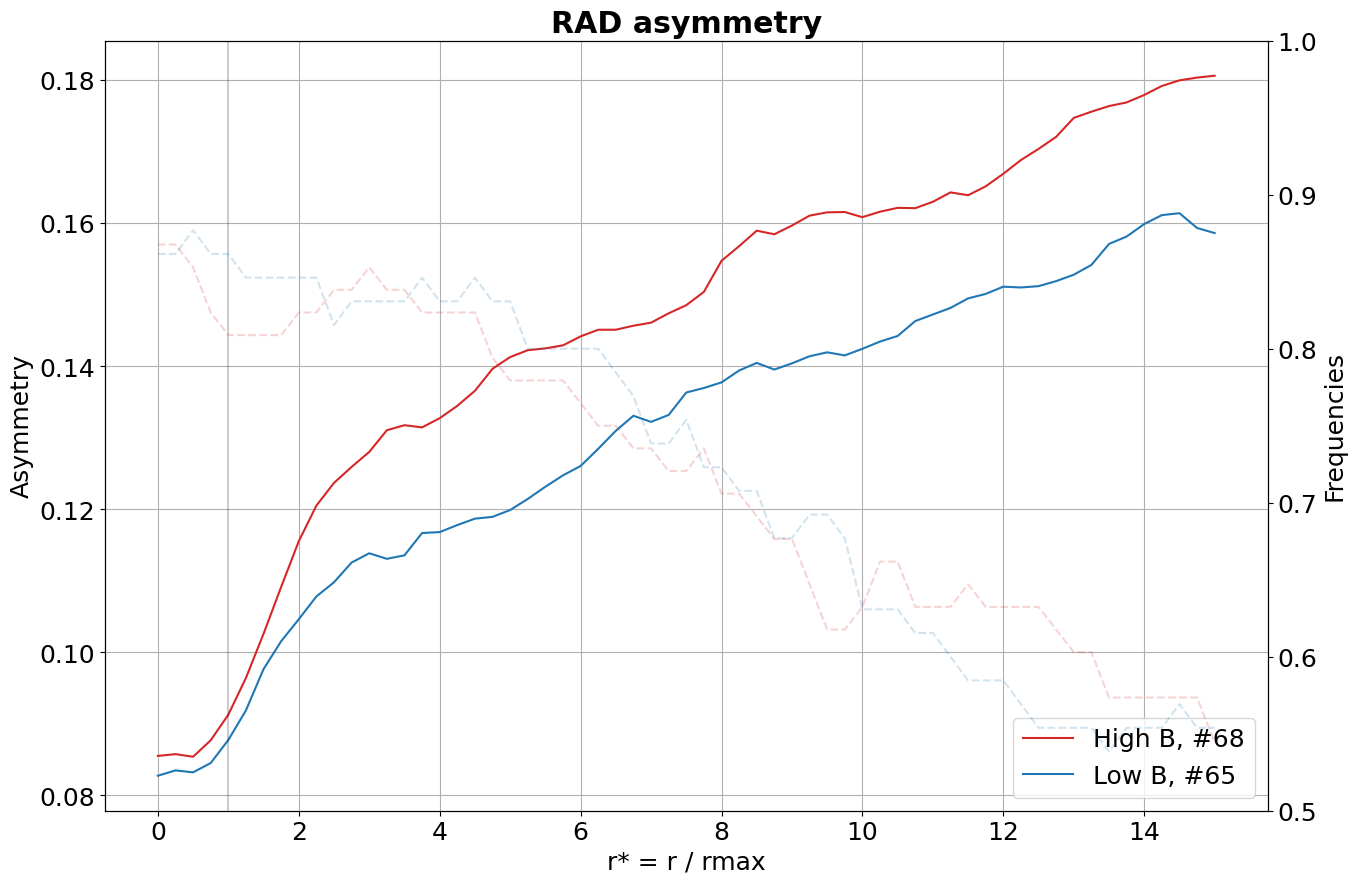

In [16]:
d = dsg.where(abs(dsg.lat_center) < 30, drop=True)
# d = d.where(d.Vmax_1D >= 20, drop=True)
# d = d.where(d.distance_to_coast > 200000, drop=True)
# d = d.where(d.Rmax_1D < 50, drop=True)
# d = d.where(d.cyclone_speed >= 4, drop=True)

d_hgh = d.where(d.B_hol > 2.2).dropna(dim='time', how='all')
d_low = d.where(d.B_hol < 1.8).dropna(dim='time', how='all')

plt.title('RAD asymmetry', weight='bold')

# Asymmetries
plt.plot(d.rad_asym, d_hgh.asym_rad.mean(dim='time', skipna=True), c='tab:red',   label='High B, #{}'.format(len(d_hgh.time)))
plt.plot(d.rad_asym, d_low.asym_rad.mean(dim='time', skipna=True), c='tab:blue',  label='Low B, #{}'.format(len(d_low.time)))
plt.axvline(1, alpha=0.2, c='k')
plt.xlabel('r* = r / rmax');plt.ylabel('Asymmetry')
plt.grid();plt.legend()

# Frequencies
ax  = plt.gca()    # Get current axis
ax2 = ax.twinx()   # Make twin axis based on x
ax2.plot(d.rad_asym, d_hgh.asym_rad.notnull().sum(dim='time') / len(d_hgh.time), c='tab:red', linestyle='--', alpha=0.2)
ax2.plot(d.rad_asym, d_low.asym_rad.notnull().sum(dim='time') / len(d_low.time), c='tab:blue', linestyle='--', alpha=0.2)
ax2.set_ylabel('Frequencies');ax2.set_ylim(0.5, 1)

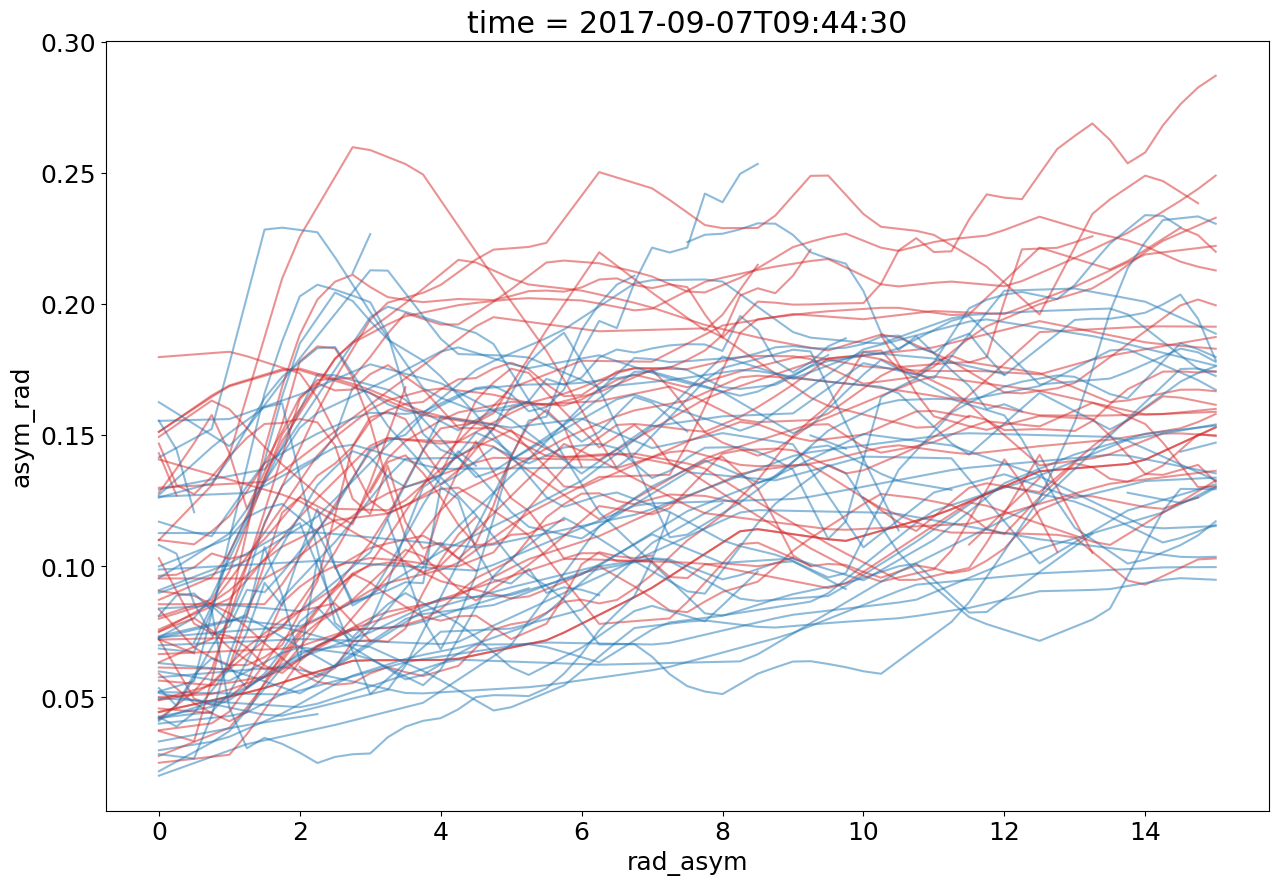

In [25]:
### EXAMINATION OF SAMPLES
for t in range(50):
    d_hgh.isel(time=t).asym_rad.plot(c='tab:red', alpha=0.5)
    d_low.isel(time=t).asym_rad.plot(c='tab:blue', alpha=0.5)
    
# Conclusion: we need to constrain further the groups using storm speed and latitude

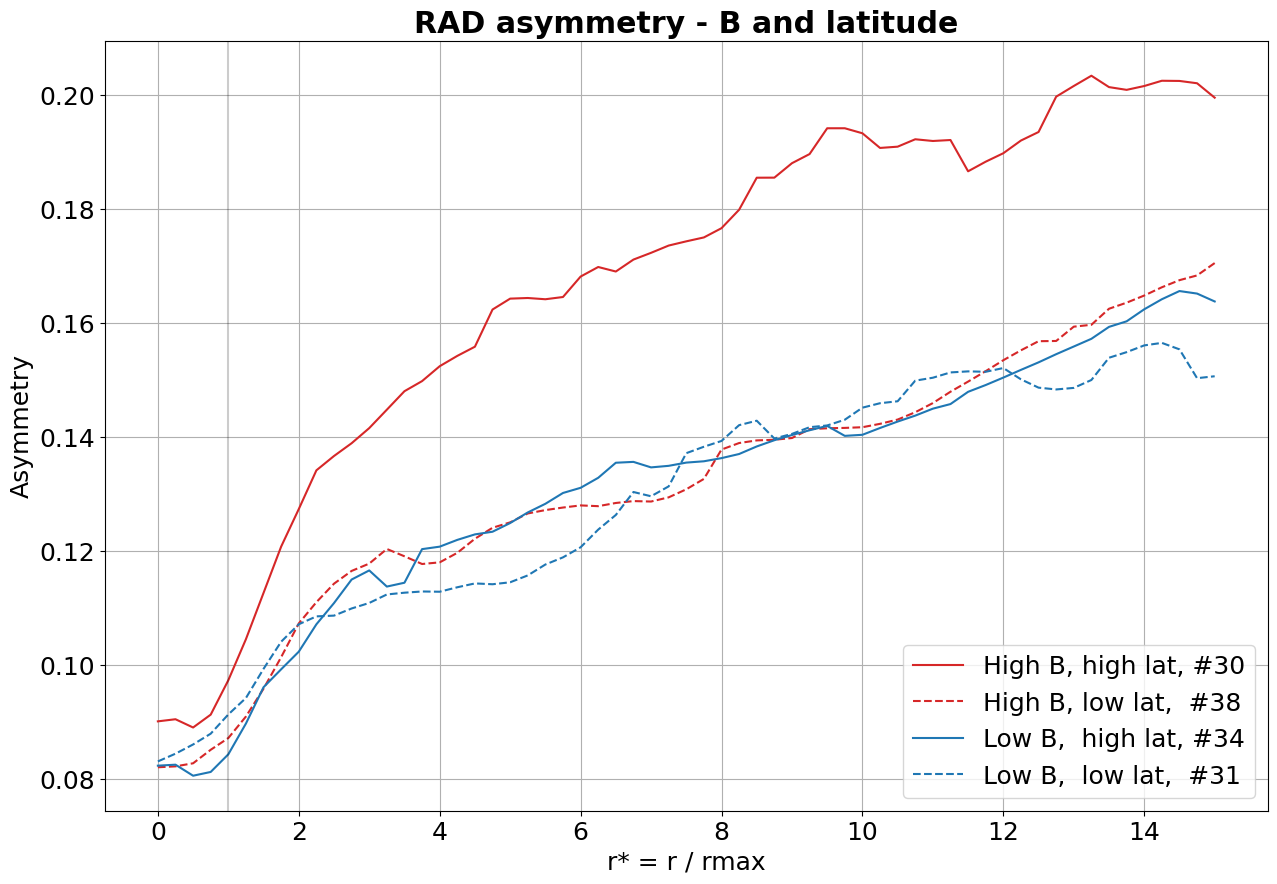

In [50]:
d = dsg.where(abs(dsg.lat_center) < 30, drop=True)
# d = d.where(d.Vmax_1D >= 20, drop=True)
# d = d.where(d.distance_to_coast > 200000, drop=True)
# d = d.where(d.Rmax_1D < 50, drop=True)
# d = d.where(d.cyclone_speed >= 4, drop=True)

d_hghB = d.where(d.B_hol > 2.2).dropna(dim='time', how='all')
d_lowB = d.where(d.B_hol < 1.8).dropna(dim='time', how='all')

d_hghB_hghlat = d_hghB.where(abs(d_hghB.lat_center) > 19).dropna(dim='time', how='all')
d_hghB_lowlat = d_hghB.where(abs(d_hghB.lat_center) < 19).dropna(dim='time', how='all')
d_lowB_hghlat = d_lowB.where(abs(d_lowB.lat_center) > 19).dropna(dim='time', how='all')
d_lowB_lowlat = d_lowB.where(abs(d_lowB.lat_center) < 19).dropna(dim='time', how='all')

plt.title('RAD asymmetry - B and latitude', weight='bold')

# Asymmetries
plt.plot(d.rad_asym, d_hghB_hghlat.asym_rad.mean(dim='time', skipna=True), c='tab:red',   label='High B, high lat, #{}'.format(len(d_hghB_hghlat.time)))
plt.plot(d.rad_asym, d_hghB_lowlat.asym_rad.mean(dim='time', skipna=True), c='tab:red',   label='High B, low lat,  #{}'.format(len(d_hghB_lowlat.time)), linestyle='--')
plt.plot(d.rad_asym, d_lowB_hghlat.asym_rad.mean(dim='time', skipna=True), c='tab:blue',  label='Low B,  high lat, #{}'.format(len(d_lowB_hghlat.time)))
plt.plot(d.rad_asym, d_lowB_lowlat.asym_rad.mean(dim='time', skipna=True), c='tab:blue',  label='Low B,  low lat,  #{}'.format(len(d_lowB_lowlat.time)), linestyle='--')
plt.axvline(1, alpha=0.2, c='k')
plt.xlabel('r* = r / rmax');plt.ylabel('Asymmetry')
plt.grid();plt.legend()

# # Frequencies
# ax  = plt.gca()    # Get current axis
# ax2 = ax.twinx()   # Make twin axis based on x
# ax2.plot(d.rad_asym, d_hgh.asym_rad.notnull().sum(dim='time') / len(d_hgh.time), c='tab:red', linestyle='--', alpha=0.2)
# ax2.plot(d.rad_asym, d_low.asym_rad.notnull().sum(dim='time') / len(d_low.time), c='tab:blue', linestyle='--', alpha=0.2)
# ax2.set_ylabel('Frequencies');ax2.set_ylim(0.5, 1)

In [51]:
# ### EXAMINATION OF SAMPLES
# for t in range(30):
#     d_hghB_hghlat.isel(time=t).asym_rad.plot(c='tab:red', alpha=0.5)
#     d_lowB_hghlat.isel(time=t).asym_rad.plot(c='tab:blue', alpha=0.5)

In [131]:
# ### EXAMINATION OF SAMPLES
# d_hB_hl_hV = d_hghB_hghlat.where(d_hghB_hghlat.Vmax_1D > 40, drop=True)
# d_lB_hl_hV = d_lowB_hghlat.where(d_lowB_hghlat.Vmax_1D > 40, drop=True)

# for t in range(6):
#     d_hB_hl_hV.isel(time=t).asym_rad.plot(c='tab:red', alpha=0.5)
#     d_lB_hl_hV.isel(time=t).asym_rad.plot(c='tab:blue', alpha=0.5)

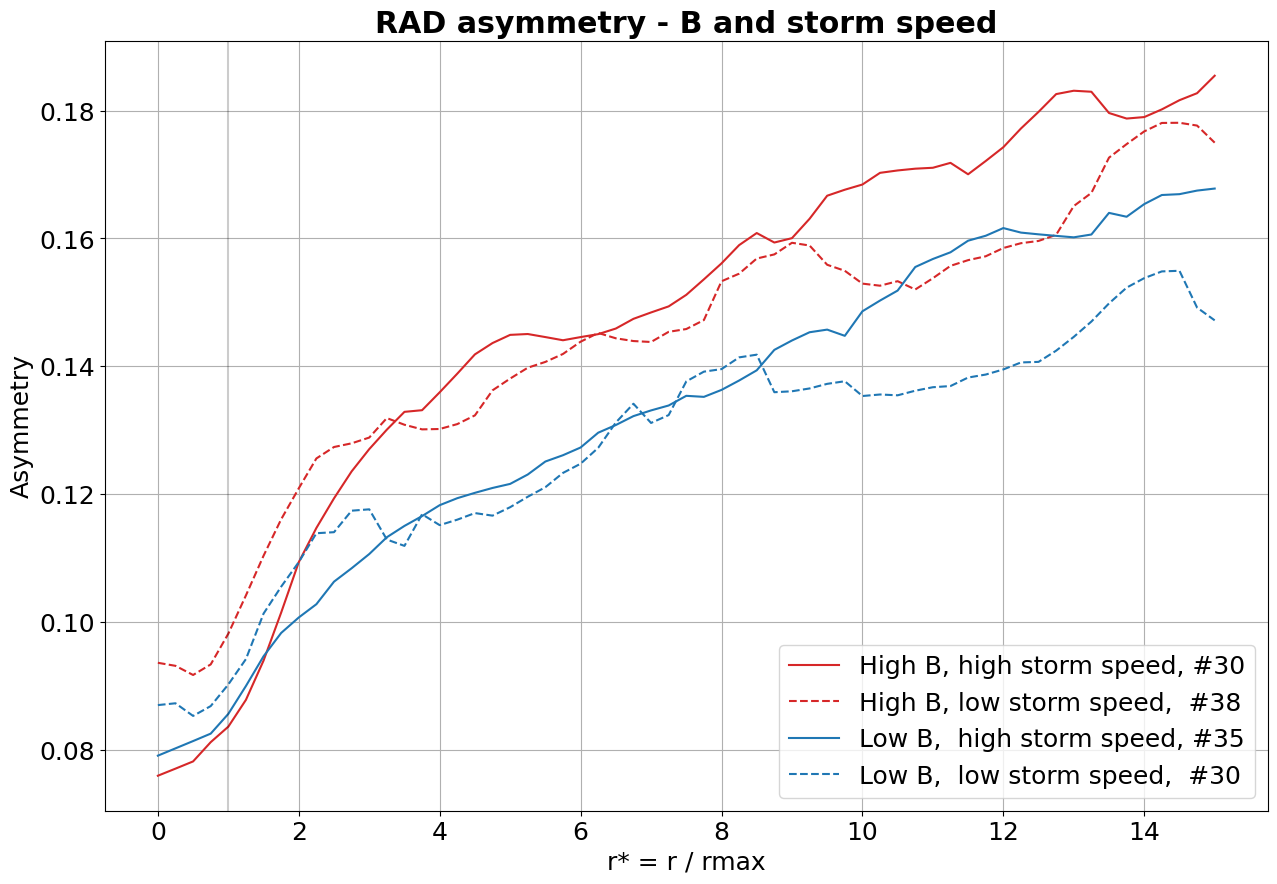

In [92]:
d = dsg.where(abs(dsg.lat_center) < 30, drop=True)
# d = d.where(d.Vmax_1D >= 20, drop=True)
# d = d.where(d.distance_to_coast > 200000, drop=True)
# d = d.where(d.Rmax_1D < 50, drop=True)
# d = d.where(d.cyclone_speed >= 4, drop=True)

d_hghB = d.where(d.B_hol > 2.2).dropna(dim='time', how='all')
d_lowB = d.where(d.B_hol < 1.8).dropna(dim='time', how='all')

d_hghB_hghUt = d_hghB.where(abs(d_hghB.cyclone_speed) > 5).dropna(dim='time', how='all')
d_hghB_lowUt = d_hghB.where(abs(d_hghB.cyclone_speed) < 5).dropna(dim='time', how='all')
d_lowB_hghUt = d_lowB.where(abs(d_lowB.cyclone_speed) > 5).dropna(dim='time', how='all')
d_lowB_lowUt = d_lowB.where(abs(d_lowB.cyclone_speed) < 5).dropna(dim='time', how='all')

plt.title('RAD asymmetry - B and storm speed', weight='bold')

# Asymmetries
plt.plot(d.rad_asym, d_hghB_hghUt.asym_rad.mean(dim='time', skipna=True), c='tab:red',   label='High B, high storm speed, #{}'.format(len(d_hghB_hghUt.time)))
plt.plot(d.rad_asym, d_hghB_lowUt.asym_rad.mean(dim='time', skipna=True), c='tab:red',   label='High B, low storm speed,  #{}'.format(len(d_hghB_lowUt.time)), linestyle='--')
plt.plot(d.rad_asym, d_lowB_hghUt.asym_rad.mean(dim='time', skipna=True), c='tab:blue',  label='Low B,  high storm speed, #{}'.format(len(d_lowB_hghUt.time)))
plt.plot(d.rad_asym, d_lowB_lowUt.asym_rad.mean(dim='time', skipna=True), c='tab:blue',  label='Low B,  low storm speed,  #{}'.format(len(d_lowB_lowUt.time)), linestyle='--')
plt.axvline(1, alpha=0.2, c='k')
plt.xlabel('r* = r / rmax');plt.ylabel('Asymmetry')
plt.grid();plt.legend()

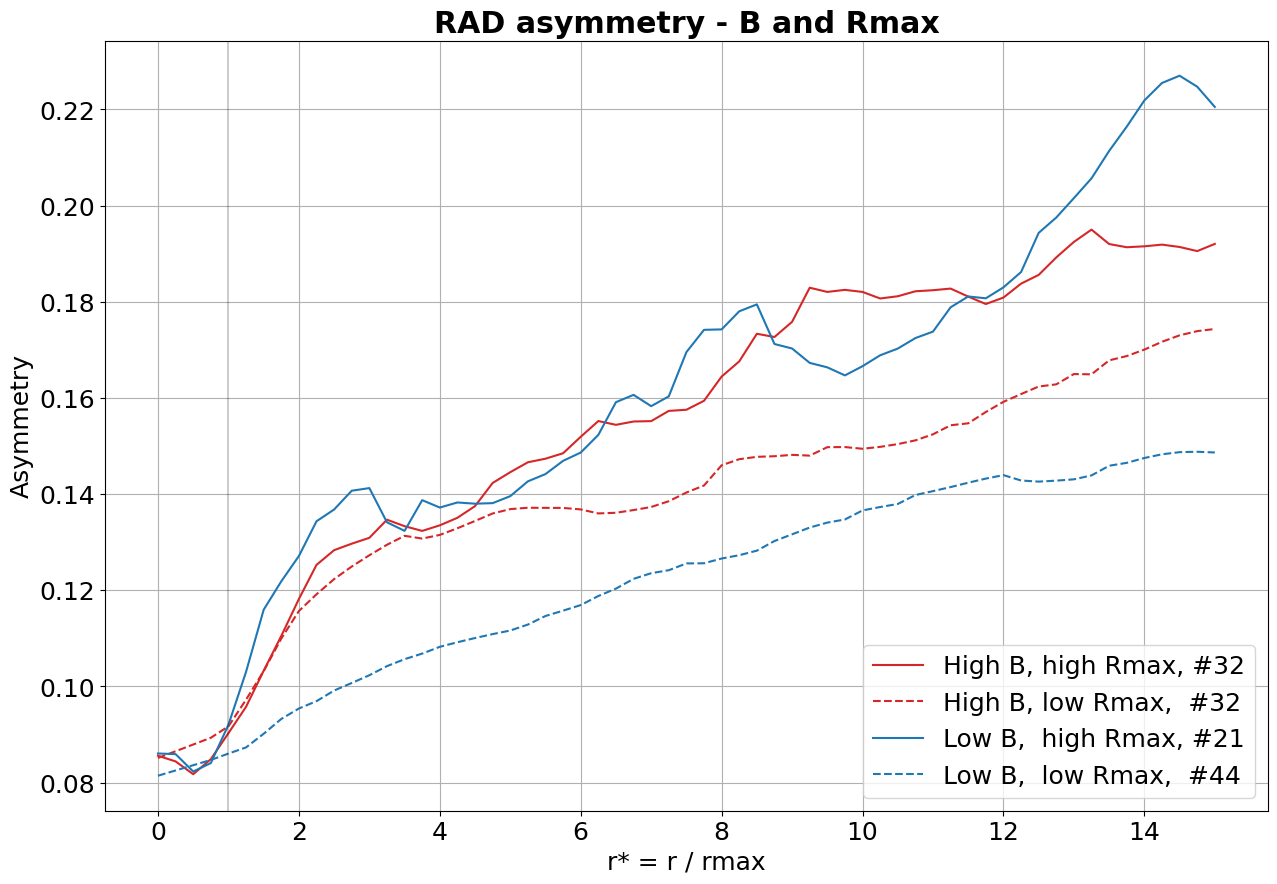

In [93]:
d = dsg.where(abs(dsg.lat_center) < 30, drop=True)
# d = d.where(d.Vmax_1D >= 20, drop=True)
# d = d.where(d.distance_to_coast > 200000, drop=True)
# d = d.where(d.Rmax_1D < 50, drop=True)
# d = d.where(d.cyclone_speed >= 4, drop=True)

d_hghB = d.where(d.B_hol > 2.2).dropna(dim='time', how='all')
d_lowB = d.where(d.B_hol < 1.8).dropna(dim='time', how='all')

d_hghB_hghrmx = d_hghB.where(abs(d_hghB.Rmax_1D) > 30).dropna(dim='time', how='all')
d_hghB_lowrmx = d_hghB.where(abs(d_hghB.Rmax_1D) < 30).dropna(dim='time', how='all')
d_lowB_hghrmx = d_lowB.where(abs(d_lowB.Rmax_1D) > 30).dropna(dim='time', how='all')
d_lowB_lowrmx = d_lowB.where(abs(d_lowB.Rmax_1D) < 30).dropna(dim='time', how='all')

plt.title('RAD asymmetry - B and Rmax', weight='bold')

# Asymmetries
plt.plot(d.rad_asym, d_hghB_hghrmx.asym_rad.mean(dim='time', skipna=True), c='tab:red',   label='High B, high Rmax, #{}'.format(len(d_hghB_hghrmx.time)))
plt.plot(d.rad_asym, d_hghB_lowrmx.asym_rad.mean(dim='time', skipna=True), c='tab:red',   label='High B, low Rmax,  #{}'.format(len(d_hghB_lowrmx.time)), linestyle='--')
plt.plot(d.rad_asym, d_lowB_hghrmx.asym_rad.mean(dim='time', skipna=True), c='tab:blue',  label='Low B,  high Rmax, #{}'.format(len(d_lowB_hghrmx.time)))
plt.plot(d.rad_asym, d_lowB_lowrmx.asym_rad.mean(dim='time', skipna=True), c='tab:blue',  label='Low B,  low Rmax,  #{}'.format(len(d_lowB_lowrmx.time)), linestyle='--')
plt.axvline(1, alpha=0.2, c='k')
plt.xlabel('r* = r / rmax');plt.ylabel('Asymmetry')
plt.grid();plt.legend()

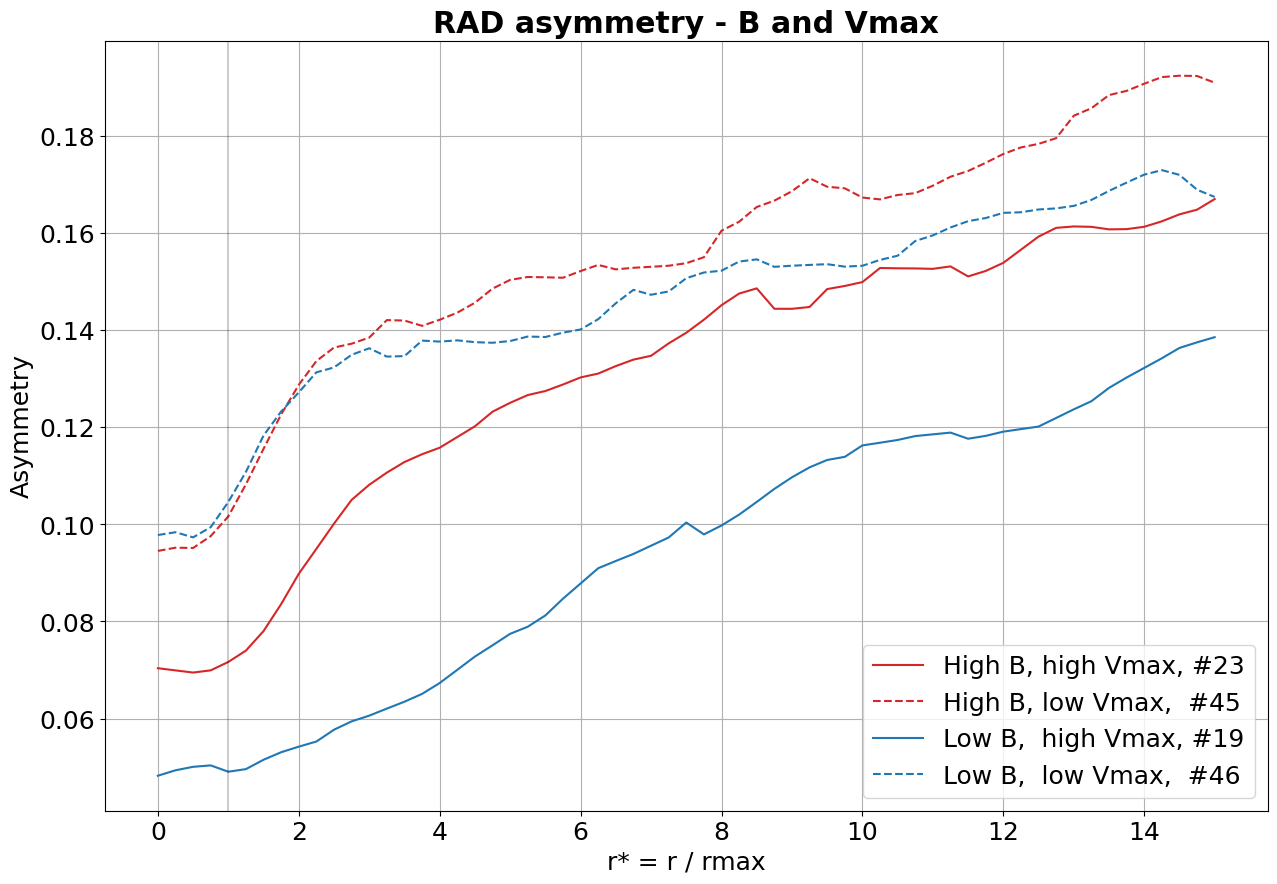

In [123]:
d = dsg.where(abs(dsg.lat_center) < 30, drop=True)
# d = d.where(d.Vmax_1D >= 20, drop=True)
# d = d.where(d.distance_to_coast > 200000, drop=True)
# d = d.where(d.Rmax_1D < 50, drop=True)
# d = d.where(d.cyclone_speed >= 4, drop=True)

d_hghB = d.where(d.B_hol > 2.2).dropna(dim='time', how='all')
d_lowB = d.where(d.B_hol < 1.8).dropna(dim='time', how='all')

d_hghB_hghvmx = d_hghB.where(abs(d_hghB.Vmax_1D) > 40).dropna(dim='time', how='all')
d_hghB_lowvmx = d_hghB.where(abs(d_hghB.Vmax_1D) < 40).dropna(dim='time', how='all')
d_lowB_hghvmx = d_lowB.where(abs(d_lowB.Vmax_1D) > 40).dropna(dim='time', how='all')
d_lowB_lowvmx = d_lowB.where(abs(d_lowB.Vmax_1D) < 40).dropna(dim='time', how='all')

plt.title('RAD asymmetry - B and Vmax', weight='bold')

# Asymmetries
plt.plot(d.rad_asym, d_hghB_hghvmx.asym_rad.mean(dim='time', skipna=True), c='tab:red',   label='High B, high Vmax, #{}'.format(len(d_hghB_hghvmx.time)))
plt.plot(d.rad_asym, d_hghB_lowvmx.asym_rad.mean(dim='time', skipna=True), c='tab:red',   label='High B, low Vmax,  #{}'.format(len(d_hghB_lowvmx.time)), linestyle='--')
plt.plot(d.rad_asym, d_lowB_hghvmx.asym_rad.mean(dim='time', skipna=True), c='tab:blue',  label='Low B,  high Vmax, #{}'.format(len(d_lowB_hghvmx.time)))
plt.plot(d.rad_asym, d_lowB_lowvmx.asym_rad.mean(dim='time', skipna=True), c='tab:blue',  label='Low B,  low Vmax,  #{}'.format(len(d_lowB_lowvmx.time)), linestyle='--')
plt.axvline(1, alpha=0.2, c='k')
plt.xlabel('r* = r / rmax');plt.ylabel('Asymmetry')
plt.grid();plt.legend()

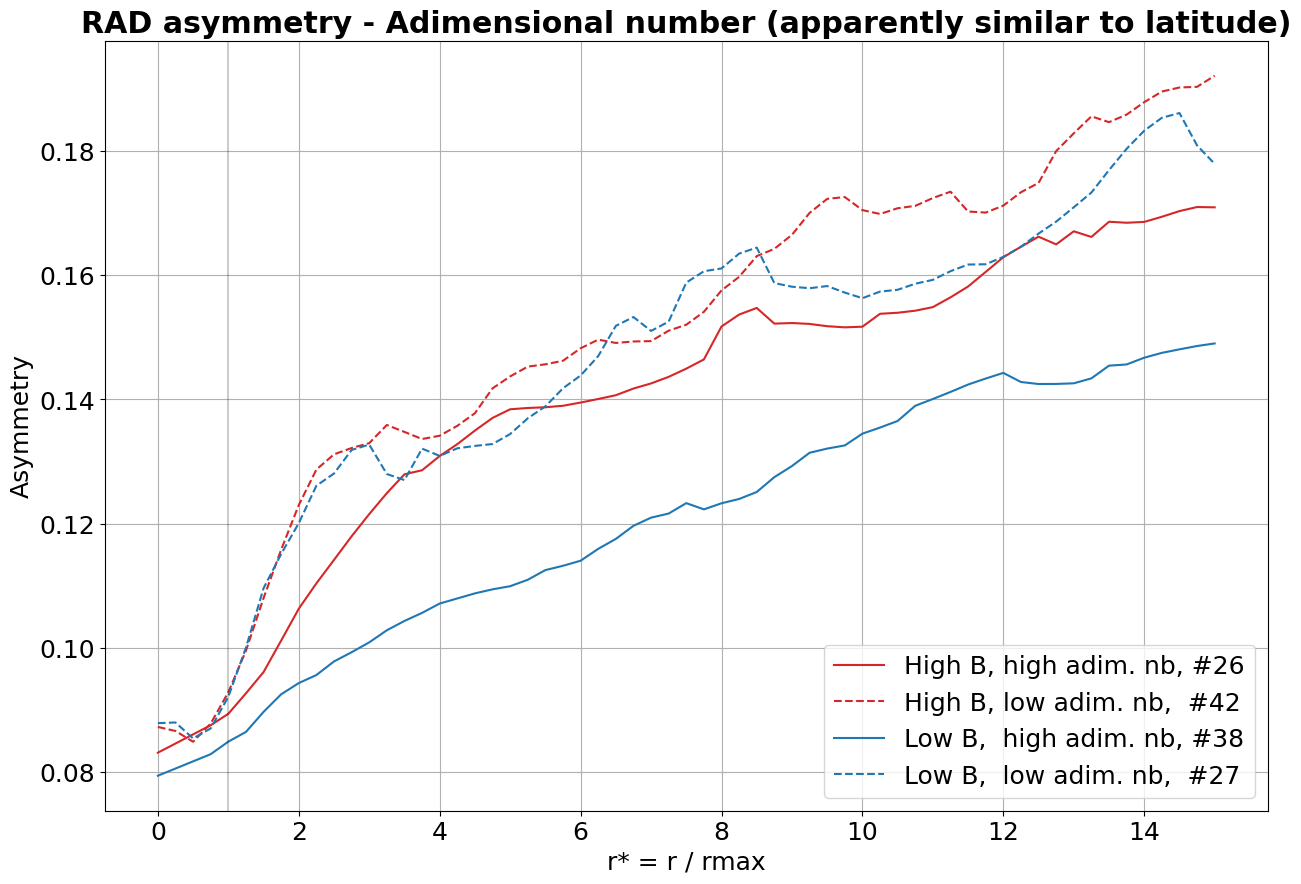

In [72]:
dsg['nb_adim'] = dsg['cyclone_speed'] / (coriolis(abs(dsg.lat_center)) * dsg.Rmax_1D * 1000)
d = dsg.where(abs(dsg.lat_center) < 30, drop=True)
# d = d.where(d.Vmax_1D >= 20, drop=True)
# d = d.where(d.distance_to_coast > 200000, drop=True)
# d = d.where(d.Rmax_1D < 50, drop=True)
# d = d.where(d.cyclone_speed >= 4, drop=True)

d_hghB = d.where(d.B_hol > 2.2).dropna(dim='time', how='all')
d_lowB = d.where(d.B_hol < 1.8).dropna(dim='time', how='all')

d_hghB_hghAdm = d_hghB.where(abs(d_hghB.nb_adim) > 4).dropna(dim='time', how='all')
d_hghB_lowAdm = d_hghB.where(abs(d_hghB.nb_adim) < 4).dropna(dim='time', how='all')
d_lowB_hghAdm = d_lowB.where(abs(d_lowB.nb_adim) > 4).dropna(dim='time', how='all')
d_lowB_lowAdm = d_lowB.where(abs(d_lowB.nb_adim) < 4).dropna(dim='time', how='all')

plt.title('RAD asymmetry - Adimensional number (apparently similar to latitude)', weight='bold')

# Asymmetries
plt.plot(d.rad_asym, d_hghB_hghAdm.asym_rad.mean(dim='time', skipna=True), c='tab:red',   label='High B, high adim. nb, #{}'.format(len(d_hghB_hghAdm.time)))
plt.plot(d.rad_asym, d_hghB_lowAdm.asym_rad.mean(dim='time', skipna=True), c='tab:red',   label='High B, low adim. nb,  #{}'.format(len(d_hghB_lowAdm.time)), linestyle='--')
plt.plot(d.rad_asym, d_lowB_hghAdm.asym_rad.mean(dim='time', skipna=True), c='tab:blue',  label='Low B,  high adim. nb, #{}'.format(len(d_lowB_hghAdm.time)))
plt.plot(d.rad_asym, d_lowB_lowAdm.asym_rad.mean(dim='time', skipna=True), c='tab:blue',  label='Low B,  low adim. nb,  #{}'.format(len(d_lowB_lowAdm.time)), linestyle='--')
plt.axvline(1, alpha=0.2, c='k')
plt.xlabel('r* = r / rmax');plt.ylabel('Asymmetry')
plt.grid();plt.legend()

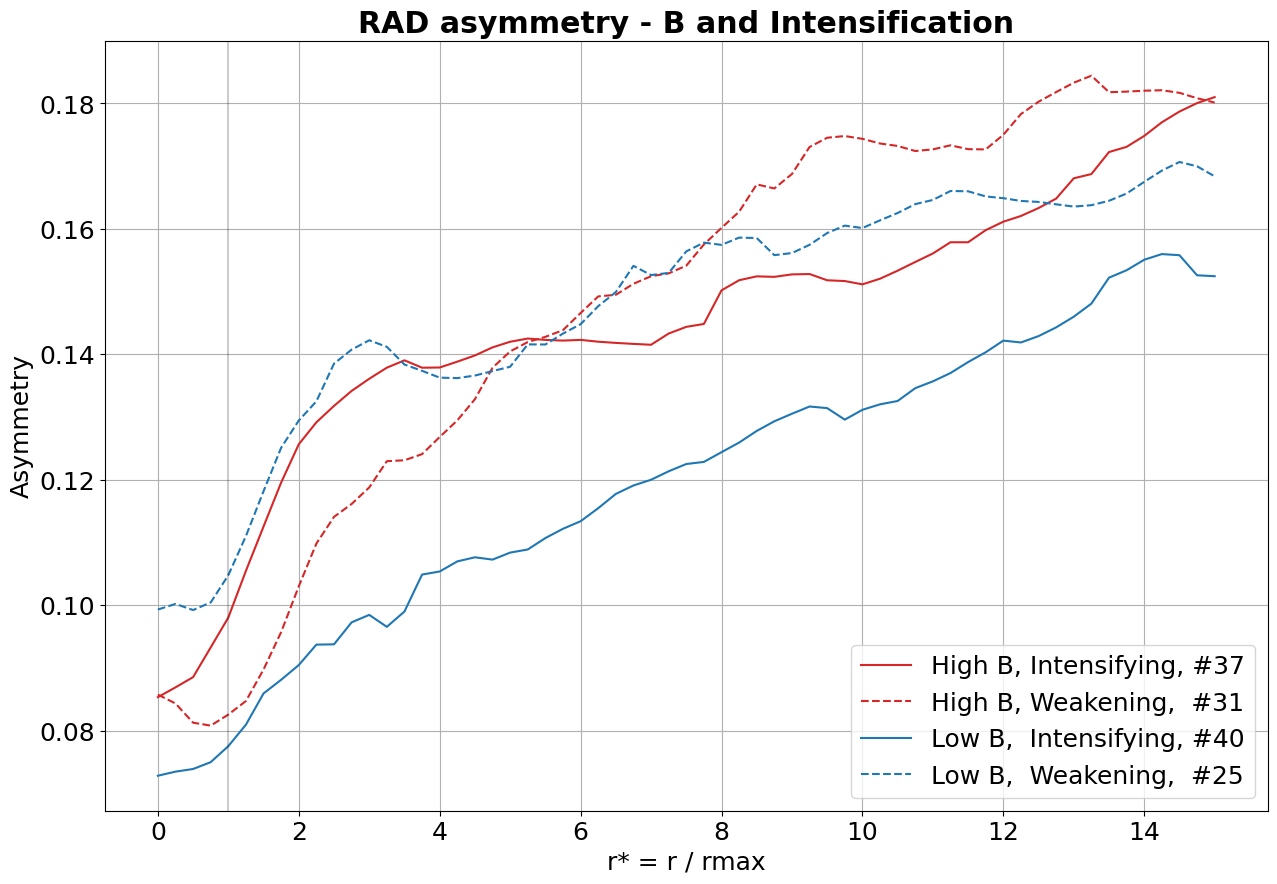

In [98]:
d = dsg.where(abs(dsg.lat_center) < 30, drop=True)
# d = d.where(d.Vmax_1D >= 20, drop=True)
# d = d.where(d.distance_to_coast > 200000, drop=True)
# d = d.where(d.Rmax_1D < 50, drop=True)
# d = d.where(d.cyclone_speed >= 4, drop=True)

d_hghB = d.where(d.B_hol > 2.2).dropna(dim='time', how='all')
d_lowB = d.where(d.B_hol < 1.8).dropna(dim='time', how='all')

d_hghB_intfyn = d_hghB.where(abs(d_hghB.Vmax_dot_smth_IBT) > 0.3).dropna(dim='time', how='all')
d_hghB_weakng = d_hghB.where(abs(d_hghB.Vmax_dot_smth_IBT) < 0.3).dropna(dim='time', how='all')
d_lowB_intfyn = d_lowB.where(abs(d_lowB.Vmax_dot_smth_IBT) > 0.3).dropna(dim='time', how='all')
d_lowB_weakng = d_lowB.where(abs(d_lowB.Vmax_dot_smth_IBT) < 0.3).dropna(dim='time', how='all')

plt.title('RAD asymmetry - B and Intensification', weight='bold')

# Asymmetries
plt.plot(d.rad_asym, d_hghB_intfyn.asym_rad.mean(dim='time', skipna=True), c='tab:red',   label='High B, Intensifying, #{}'.format(len(d_hghB_intfyn.time)))
plt.plot(d.rad_asym, d_hghB_weakng.asym_rad.mean(dim='time', skipna=True), c='tab:red',   label='High B, Weakening,  #{}'.format(len(d_hghB_weakng.time)), linestyle='--')
plt.plot(d.rad_asym, d_lowB_intfyn.asym_rad.mean(dim='time', skipna=True), c='tab:blue',  label='Low B,  Intensifying, #{}'.format(len(d_lowB_intfyn.time)))
plt.plot(d.rad_asym, d_lowB_weakng.asym_rad.mean(dim='time', skipna=True), c='tab:blue',  label='Low B,  Weakening,  #{}'.format(len(d_lowB_weakng.time)), linestyle='--')
plt.axvline(1, alpha=0.2, c='k')
plt.xlabel('r* = r / rmax');plt.ylabel('Asymmetry')
plt.grid();plt.legend()

In [117]:
# ### EXAMINATION OF SAMPLES
# for t in range(30):
#     d_hghB_intfyn.isel(time=t).asym_rad.plot(c='tab:red', alpha=0.5)
#     d_lowB_intfyn.isel(time=t).asym_rad.plot(c='tab:blue', alpha=0.5)

In [113]:
# d = dsg.where(abs(dsg.lat_center) < 30, drop=True)

# plt.title('Asymmetry colored by Holland B', weight='bold')
# plt.scatter(abs(d.lat_center), d.sel(rad_asym=4, method='nearest').asym_rad, c=d.B_hol, cmap=cm.get_cmap('coolwarm', 3), vmin=1.2, vmax=2.8);plt.grid();plt.colorbar()
# plt.xlabel('Latitude (°)');plt.ylabel('Asym. at r = 4 rmax')

In [12]:
### Here, we downsampled SAR data using [::25, ::25] to mimic radiometer resolution
### So I also had to change the valids_sar criteria: nb of valid thetas must be > 200 / 25

listOfDatasets = []

for i, _ in tqdm(enumerate(ds_col.i)):
    # Open files
    dsc         = ds_col.isel(i=i)
    sar_pth     = dsc.sar_pth.item()
    rad_pth     = dsc.rad_pth.item()
    ds_sar      = xr.open_dataset(sar_pth).isel(time=0)
    ds_rad      = xr.open_dataset(rad_pth)

    ### ==> ASYMMETRIES
    dss          = dsg_sar.where(dsg_sar.sat_pth == sar_pth, drop=True).isel(time=0)
    rs_star      = np.linspace(0, 8, 81)
    # std_prof_sar = (ds_sar.wind_speed / ds_sar.wind_speed.max(dim=['theta'])).std(dim='theta', skipna=True)
    std_prof_sar = (ds_sar.wind_speed[::25, ::25] / ds_sar.wind_speed[::25, ::25].max(dim=['theta'])).std(dim='theta', skipna=True)
    std_prof_rad = (ds_rad.wind_speed / ds_rad.wind_speed.max(dim=['theta'])).std(dim='theta', skipna=True)
    if ~np.isnan(dss.Rmax_1D):
        # Radiometer asymmetry must be valid
        valids_rad = ds_rad.where(ds_rad.wind_speed.notnull().sum(dim='theta') > 200) # Possible points: 361 (= range of thetas vector)
        if (len(valids_rad.rad) > 2) and (valids_rad.rad[-1] > 200): # Requires that radiometer is valid at least up to 200 km
            msk_rad               = np.isnan(valids_rad.lat_IBT)
            std_prof_rad[msk_rad] = np.nan
            
            # SAR asymmetry must be valid
            # valids_sar = ds_sar.where(ds_sar.wind_speed.notnull().sum(dim='theta') > 200)
            valids_sar = ds_sar.where(ds_sar.wind_speed[::25, ::25].notnull().sum(dim='theta') > 200 // 25)
            if (len(valids_sar.rad) > 2):
                msk_sar = np.isnan(valids_sar.wind_speed.mean(dim='theta'))
                std_prof_sar[msk_sar] = np.nan
                
                # Then inner-core of SAR must be valid, to compute Rmax and B properly
                if (ds_sar.wind_speed.sel(rad=slice(0, 100000)).notnull().sum() > 25000): # Possible points: 101 * 360 = 36360

                    # Normalize r-axis
                    std_prof_sar['rad'] = std_prof_sar.rad / 1000 / dss.Rmax_1D # Convert SAR from meters to km, then normalize by Rmax
                    std_prof_rad['rad'] = std_prof_rad.rad / dss.Rmax_1D        # RAD is already in km, so we only normalize by Rmax

                    # SAR
                    dss['asym_sar'] = xr.DataArray(
                        data=np.array(std_prof_sar.interp({'rad': rs_star})),
                        coords={'rad_asym': rs_star}
                    )
                    # RAD
                    dss['asym_rad'] = xr.DataArray(
                        data=np.array(std_prof_rad.interp({'rad': rs_star})),
                        coords={'rad_asym': rs_star}
                    )           

                    listOfDatasets.append(dss)
                
print('Concatenating all datasets into ds_glob. Can take a few seconds...')
dsg2 = xr.concat(listOfDatasets, dim='time') # Concatenate all datasets into a global dataset
print('Concatenation ended.')

0it [00:00, ?it/s]

Concatenating all datasets into ds_glob. Can take a few seconds...
Concatenation ended.


(0.5, 1.01)

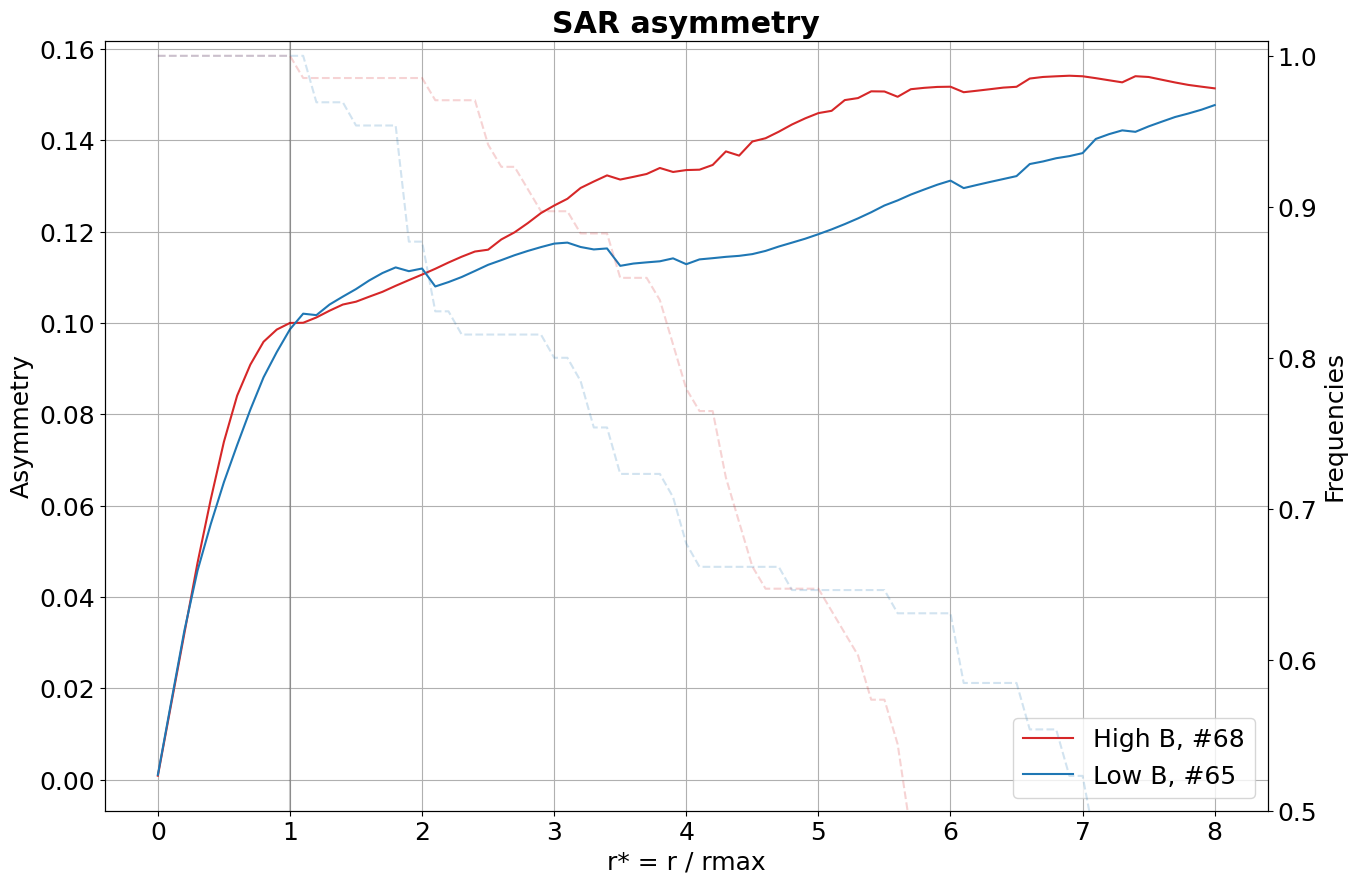

In [14]:
d = dsg2.where(abs(dsg2.lat_center) < 30, drop=True)
# d = d.where(d.Vmax_1D >= 20, drop=True)
# d = d.where(d.distance_to_coast > 200000, drop=True)
# d = d.where(d.Rmax_1D < 50, drop=True)
# d = d.where(d.cyclone_speed >= 4, drop=True)

d_hgh = d.where(d.B_hol > 2.2).dropna(dim='time', how='all')
d_low = d.where(d.B_hol < 1.8).dropna(dim='time', how='all')

plt.title('SAR asymmetry', weight='bold')

# Asymmetries
plt.plot(d.rad_asym, d_hgh.asym_sar.mean(dim='time', skipna=True), c='tab:red',   label='High B, #{}'.format(len(d_hgh.time)))
plt.plot(d.rad_asym, d_low.asym_sar.mean(dim='time', skipna=True), c='tab:blue',  label='Low B, #{}'.format(len(d_low.time)))
plt.axvline(1, alpha=0.2, c='k')
plt.xlabel('r* = r / rmax');plt.ylabel('Asymmetry')
plt.grid();plt.legend()

# Frequencies
ax  = plt.gca()    # Get current axis
ax2 = ax.twinx()   # Make twin axis based on x
ax2.plot(d.rad_asym, d_hgh.asym_sar.notnull().sum(dim='time') / len(d_hgh.time), c='tab:red', linestyle='--', alpha=0.2)
ax2.plot(d.rad_asym, d_low.asym_sar.notnull().sum(dim='time') / len(d_low.time), c='tab:blue', linestyle='--', alpha=0.2)
ax2.set_ylabel('Frequencies');ax2.set_ylim(0.5, 1.01)